<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Hochschule-esslingen.svg/320px-Hochschule-esslingen.svg.png" />

<br>Name: Panagiotis Theofanidis, 761737
<br>Team Name: EZ3DML
<br>Studiengang: SWB
<br>E-mail: pathit01@hs-esslingen.de

<br>Lecture: Applied Artificial Intelligence
<br>Semseter: SS2023
<br>Lecturers: Dionysios Satikidis (dionysios.satikidis@gmail.com); Jan Seyler (jan.seyler@gmail.com)


***

## Import


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# tfg for Chamfer Distance (loss function) and trimesh to load 3D meshes and sample point clouds
!pip install tensorflow-graphics trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.6/681.6 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.7 MB/s eta 0:00:00


In [3]:
import os
import glob
import time
import concurrent.futures
from pathlib import Path

from IPython.display import clear_output
import imageio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_graphics.nn.loss import chamfer_distance


In [ ]:
# Show GPU info
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
if 'google.colab' in str(get_ipython()):
    !nvidia-smi


In [4]:
# Package Path (this needs to be adapted)
package_path = "./" # local
if 'google.colab' in str(get_ipython()):
  package_path = '/content/drive/MyDrive/colab/aai/'

In [ ]:
#drive.flush_and_unmount()

## Read

In [ ]:
# Download ModelNet40 Dataset
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://modelnet.cs.princeton.edu/ModelNet40.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet40")


In [ ]:
# Here are all the model classes
os.listdir(DATA_DIR)

['sofa',
 'mantel',
 'cup',
 'bench',
 'glass_box',
 'person',
 'desk',
 'car',
 'lamp',
 'flower_pot',
 'toilet',
 'bottle',
 'stool',
 'radio',
 'curtain',
 'plant',
 'range_hood',
 'laptop',
 'table',
 'chair',
 'sink',
 'bowl',
 'tv_stand',
 'keyboard',
 'wardrobe',
 'xbox',
 'monitor',
 'vase',
 'dresser',
 'bed',
 'cone',
 'night_stand',
 'stairs',
 'tent',
 'airplane',
 'door',
 'guitar',
 'piano',
 'bathtub',
 'bookshelf']

In [ ]:
# Mesh Example
mesh = trimesh.load(os.path.join(DATA_DIR, "airplane/train/airplane_0201.off"))
mesh.show()


# Clear and prepare data

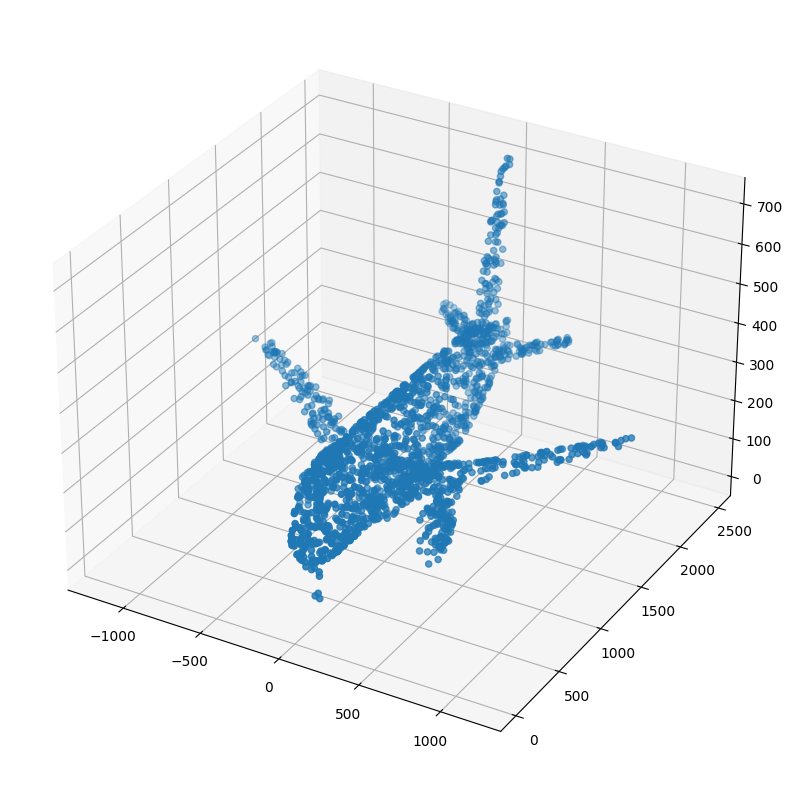

In [ ]:
# We want to train on point clouds but we have meshes so we need do a conversion
# Sampling example
points = mesh.sample(2048)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
plt.show()


In [10]:
NUM_POINTS = 2048
BATCH_SIZE = 16


In [ ]:
def parse_mesh(f):
    print(f"Processing {f}")
    return trimesh.load(f).sample(NUM_POINTS)

# Parse all meshes into train and test point clouds
# Dataset is already splitted into train and test folders
train_files = Path(os.path.join(DATA_DIR, "airplane/train")).glob("*")
test_files = Path(os.path.join(DATA_DIR, "airplane/test")).glob("*")
# Multiprocessing
with concurrent.futures.ProcessPoolExecutor() as executor:
    train_pointclouds_gen = executor.map(parse_mesh, train_files)
    test_pointclouds_gen = executor.map(parse_mesh, test_files)


Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0161.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0400.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0595.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0614.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0435.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0490.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0101.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0071.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0010.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0483.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0070.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0236.off
Processing /root/.keras/datasets/ModelNet40/airplane/train/airplane_0475.off

In [ ]:
# DO NOT RUN MORE THAN ONCE
# DO NOT RUN MORE THAN ONCE
# DO NOT RUN MORE THAN ONCE

# map returns a generator, so we need to read the results now
train_pointclouds = []
for pointcloud in train_pointclouds_gen:
    train_pointclouds.append(pointcloud)
train_pointclouds = np.array(train_pointclouds)

test_pointclouds = []
for pointcloud in test_pointclouds_gen:
    test_pointclouds.append(pointcloud)
test_pointclouds = np.array(test_pointclouds)

print(f"Train Pointclouds Shape: {train_pointclouds.shape}")
print(f"Test Pointclouds Shape: {test_pointclouds.shape}")


Train Pointclouds Shape: (626, 2048, 3)
Test Pointclouds Shape: (100, 2048, 3)


In [ ]:
# Data normalization
train_mean = np.mean(train_pointclouds, axis=(0, 1), keepdims=True)
train_std = np.std(train_pointclouds, axis=(0, 1), keepdims=True)

train_pointclouds = (train_pointclouds - train_mean) / train_std
test_pointclouds = (test_pointclouds - train_mean) / train_std

In [ ]:
def augment(points):
    # jitter points
    points -= 0.005
    points += tf.random.uniform(points.shape, 0, 0.01, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points


# Output should be equal to the input for an Autoencoder
train_dataset = tf.data.Dataset.from_tensor_slices((train_pointclouds))
test_dataset = tf.data.Dataset.from_tensor_slices((test_pointclouds))

train_dataset = train_dataset.shuffle(len(train_pointclouds)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_pointclouds)).batch(BATCH_SIZE)


# Algorithm / Network

In [11]:
class CVAE(tf.keras.Model):
    # Convolutional variational autoencoder

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(NUM_POINTS, 3)),
                tf.keras.layers.Conv1D(
                    filters=16, kernel_size=3, strides=2, activation='relu'),
                tf.keras.layers.Conv1D(
                    filters=16, kernel_size=3, strides=2, activation='relu'),
                tf.keras.layers.Conv1D(
                    filters=32, kernel_size=3, strides=2, activation='relu'),
                tf.keras.layers.Conv1D(
                    filters=64, kernel_size=3, strides=2, activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim)
        ])

        print(self.encoder.summary())

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim)),
                tf.keras.layers.Dense(units=(NUM_POINTS//4)*3, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(NUM_POINTS//4, 3)),
                tf.keras.layers.Conv1DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv1DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv1D(
                    filters=3, kernel_size=1, strides=1, padding='same')
            ]
        )

        print(self.decoder.summary())

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        eps=tf.debugging.check_numerics(eps,'eps is nan in sample')
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        x=tf.debugging.check_numerics(x,'x is nan in encode')
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        mean=tf.debugging.check_numerics(mean,'mean is nan in reparametrize')
        logvar=tf.debugging.check_numerics(logvar,'logvar is nan in reparametrize')
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        z=tf.debugging.check_numerics(z,'z is nan in decode')
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


In [12]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    x=tf.debugging.check_numerics(x,'x is nan in compute_loss before cast')
    x = tf.cast(x, tf.float32)
    x=tf.debugging.check_numerics(x,'x is nan in compute_loss after cast')

    mean, logvar = model.encode(x)
    mean=tf.debugging.check_numerics(mean,'mean is nan in computes_loss')
    logvar=tf.debugging.check_numerics(logvar,'logvar is nan in compute_loss')

    z = model.reparameterize(mean, logvar)
    z=tf.debugging.check_numerics(z,'z is nan in compute_loss')
    x_logit = model.decode(z)

    # cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

    x_pred = tf.sigmoid(x_logit)
    chamfer_dist = -tf.sigmoid(chamfer_distance.evaluate(x, x_pred))

    # logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    # return -tf.reduce_mean(logpx_z + logpz - logqz_x - chamfer_dist)
    return -tf.reduce_mean(logpz - logqz_x - chamfer_dist)
    # return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
      loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [277]:
from keras import backend as K
try:
    del model
except NameError:
    pass
K.clear_session()

In [13]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 16
num_examples_to_generate = 1

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1023, 16)          160       
                                                                 
 conv1d_1 (Conv1D)           (None, 511, 16)           784       
                                                                 
 conv1d_2 (Conv1D)           (None, 255, 32)           1568      
                                                                 
 conv1d_3 (Conv1D)           (None, 127, 64)           6208      
                                                                 
 flatten (Flatten)           (None, 8128)              0         
                                                                 
 dense (Dense)               (None, 32)                260128    
                                                                 
Total params: 268,848
Trainable params: 268,848
Non-trai

## Training

In [14]:
def generate_and_save_images(model, epoch, test_sample):
    first_test_sample = test_sample[0]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(first_test_sample[:, 0], first_test_sample[:, 1], first_test_sample[:, 2])
    plt.show()

    mean, logvar = model.encode(test_sample)
    print(mean)
    print(logvar)
    z = model.reparameterize(mean, logvar)
    z=tf.debugging.check_numerics(z,'z is nan in images')
    predictions = model.sample(z)
    print(predictions)

    first_prediction = predictions[0]
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(first_prediction[:, 0], first_prediction[:, 1], first_prediction[:, 2])
    plt.show()

    fig.savefig(f"/content/drive/MyDrive/aai_epochs2/image_at_epoch_{epoch:04d}.png")
    plt.show()



In [280]:
# Pick a batch of the test set for generating output pointclouds
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate]


Epoch: 218, Test set ELBO: 0.9956405758857727, time elapsed for current epoch: 20.78998327255249


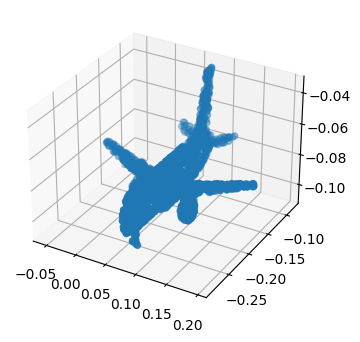

tf.Tensor(
[[ 0.00442795  0.00654019  0.00476666 -0.00433731  0.00022825  0.00146198
  -0.00302364  0.00336436  0.00026129  0.0064724   0.0001374  -0.00334293
  -0.00109695 -0.00035583  0.00057578  0.00257038]], shape=(1, 16), dtype=float32)
tf.Tensor(
[[-0.00552338 -0.00307986 -0.00395654  0.00246797 -0.00257948  0.00577302
  -0.00826589  0.00401678 -0.01112618 -0.00759424  0.00085736  0.00117547
  -0.00659898  0.00441206  0.00182914  0.00259925]], shape=(1, 16), dtype=float32)
tf.Tensor(
[[[0.99979323 0.9996346  0.9997304 ]
  [0.9999931  0.99998987 0.99999213]
  [0.9999975  0.9999951  0.999997  ]
  ...
  [0.9999964  0.9999949  0.9999957 ]
  [0.9999931  0.99998665 0.9999914 ]
  [0.9999378  0.9999217  0.99993205]]], shape=(1, 2048, 3), dtype=float32)


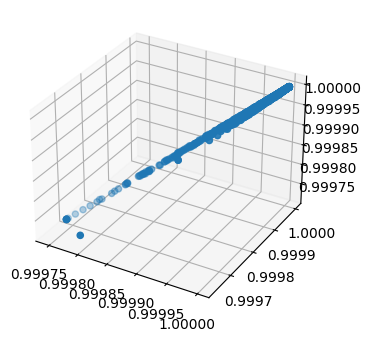

In [ ]:
# generate_and_save_images(model, 0, test_sample)

model.load_weights(f"/content/drive/MyDrive/aai_model2.ckpt")

epochs = 2000
for epoch in range(1, epochs + 1):

    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    clear_output()
    print('Epoch: {}, Test set ELBO: {}, time elapsed for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)
    model.save_weights(f"/content/drive/MyDrive/aai_model2.ckpt")

In [17]:
anim_file = '/content/drive/MyDrive/aai_epochs2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/aai_epochs2/image_at_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


<ipython-input-17-a3d68ea8d22f>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-17-a3d68ea8d22f>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


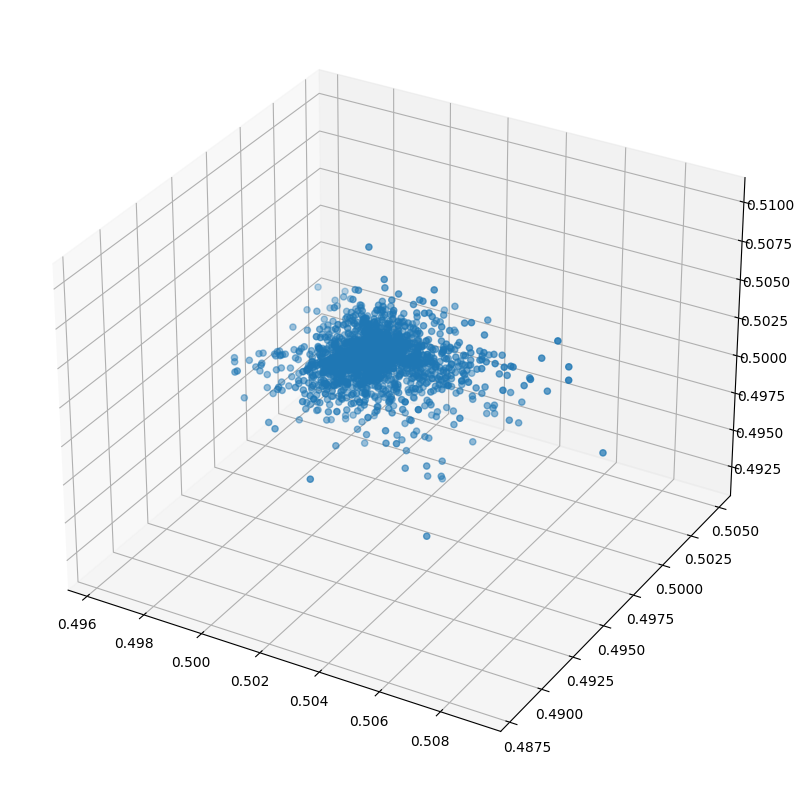

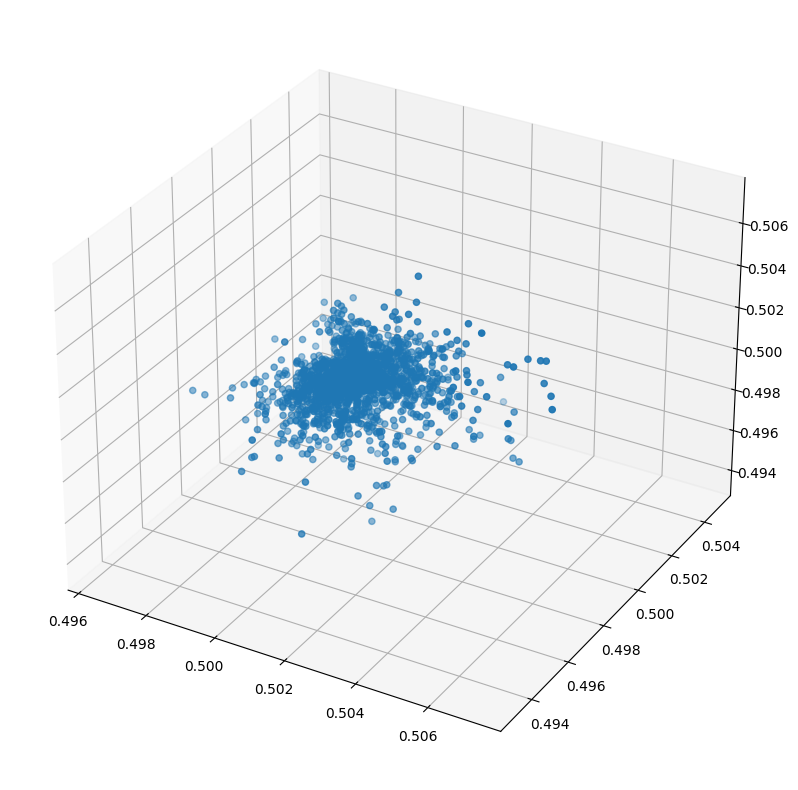

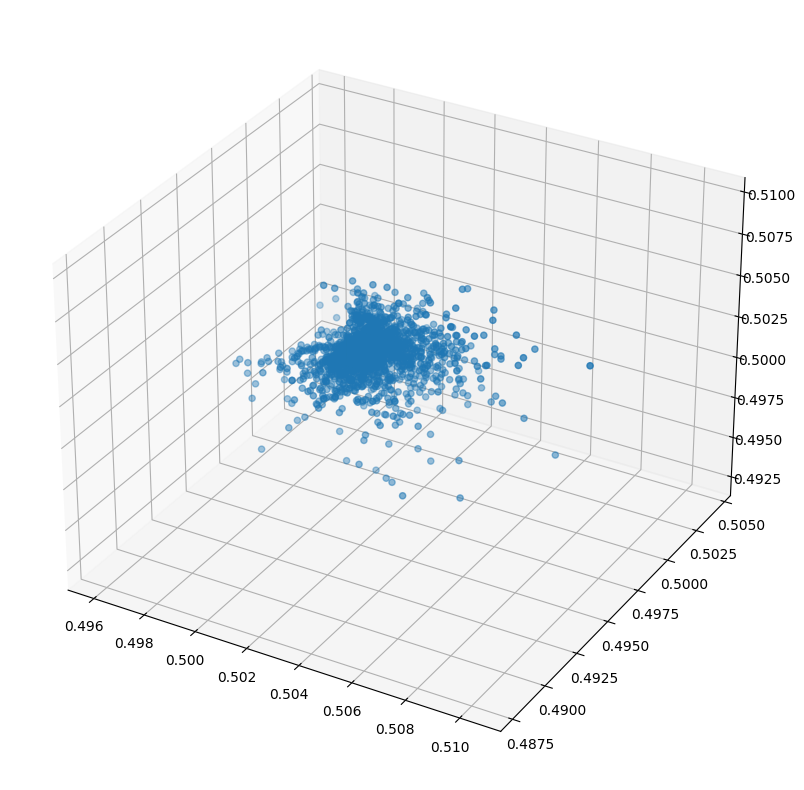

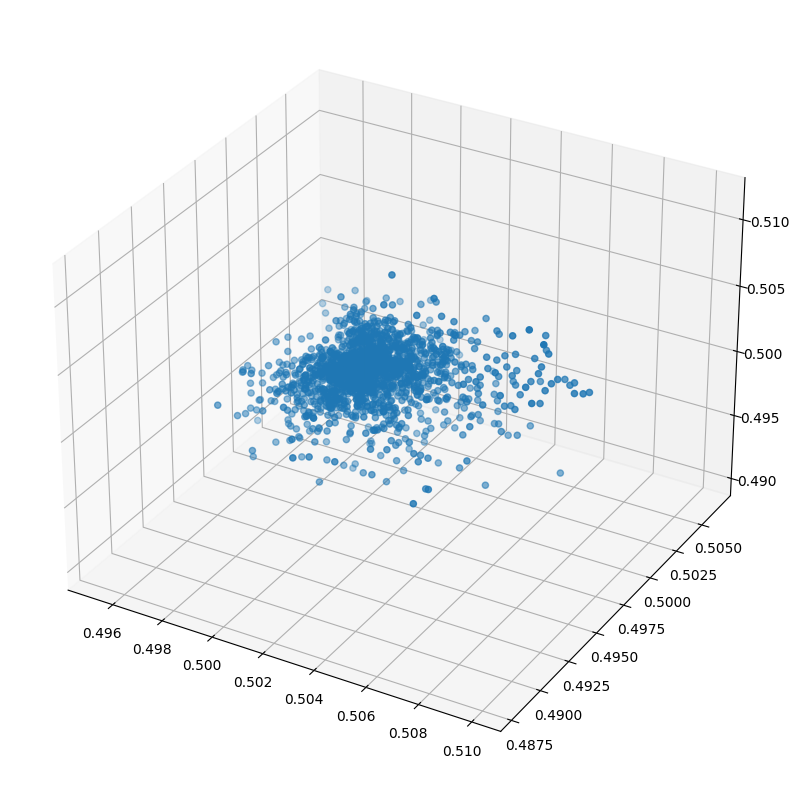

In [25]:
random_samples = model.sample()

for i in range(4):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    sample = random_samples[i]
    ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])
    plt.show()

